In [93]:
import sys
import json
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))

from protocol.scoring.post_scorer import PostScorer

In [94]:
# Load query results from JSON file
data_path = Path('../data/posts.json')
with open(data_path, 'r') as f:
    query_results = json.load(f)

print(f"Loaded {len(query_results)} query results")

# Count unique UIDs and X user IDs
unique_uids = len(set(result['uid'] for result in query_results))
unique_x_user_ids = len(set(result['user_id'] for result in query_results))
print(f"Number of unique UIDs: {unique_uids}")
print(f"Number of unique X user ids: {unique_x_user_ids}")

# Count unique X posts
unique_tweet_ids = set()
for result in query_results:
    for tweet in result['tweets']:
        tweet_id = tweet['Tweet'].get('ID')
        if tweet_id:
            unique_tweet_ids.add(tweet_id)

print(f"Number of unique X posts: {len(unique_tweet_ids)}")

# Print detailed stats
total_queries = len(query_results)
total_tweets = sum(len(result['tweets']) for result in query_results)
unique_tweets = len(unique_tweet_ids)

print(f"\nDetailed Statistics:")
print(f"Total query results: {total_queries}")
print(f"Total X posts: {total_tweets}")
print(f"Unique X posts: {unique_tweets}")

# Check for queries with no tweets
empty_queries = sum(1 for result in query_results if len(result['tweets']) == 0)
print(f"Queries with no tweets: {empty_queries}")

Loaded 1318 query results
Number of unique UIDs: 157
Number of unique X user ids: 158
Number of unique X posts: 3080

Detailed Statistics:
Total query results: 1318
Total X posts: 3080
Unique X posts: 3080
Queries with no tweets: 0


In [95]:
# Create dictionaries to store tweets per user and user relationships
user_tweet_counts = {}
user_tweets = {}
uid_user_ids = {}  # Track multiple user_ids per uid

for result in query_results:
    user_id = result['user_id']
    uid = result['uid']
    subnet_id = result['subnet_id']
    
    # Track uid to user_id relationships
    if uid not in uid_user_ids:
        uid_user_ids[uid] = set()
    uid_user_ids[uid].add(user_id)
    
    if user_id not in user_tweets:
        user_tweets[user_id] = set()
    
    for tweet in result['tweets']:
        tweet_id = tweet['Tweet'].get('ID')
        if tweet_id:
            user_tweets[user_id].add(tweet_id)
            user_tweet_counts[user_id] = {
                'uid': uid,
                'subnet_id': subnet_id,
                'tweet_count': len(user_tweets[user_id])
            }

# Convert to DataFrame
df_users = pd.DataFrame([
    {'user_id': user_id, **stats}
    for user_id, stats in user_tweet_counts.items()
])
df_users = df_users.sort_values('tweet_count', ascending=False)

# Save to CSV
output_dir = '../data/csv'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'user_tweet_counts.csv')
df_users.to_csv(output_path, index=False)

# Print statistics about the uid to user_id relationships
print("\nUID to User ID relationships:")
for uid, user_ids in uid_user_ids.items():
    if len(user_ids) > 1:
        print(f"UID {uid} has {len(user_ids)} different user_ids: {user_ids}")
print(f"Total unique UIDs: {len(uid_user_ids)}")
print(f"Total unique X user ids: {len(user_tweet_counts)}")
print(f"Total unique tweets across all users: {sum(len(tweets) for tweets in user_tweets.values())}")
print(f"\nData saved to: {output_path}")
display(df_users)


UID to User ID relationships:
UID 25 has 2 different user_ids: {'3313768127', '1267270952'}
Total unique UIDs: 157
Total unique X user ids: 158
Total unique tweets across all users: 3080

Data saved to: ../data/csv/user_tweet_counts.csv


,user_id,uid,subnet_id,tweet_count
12,20510925,23,59,366
86,1770087158440976384,170,59,267
13,1675866018235965441,117,59,104
125,1859934851828195328,138,59,96
80,1152727572,158,59,77
...,...,...,...,...
60,628114213,34,59,1
130,1574768678507511808,175,59,1
94,1446355232439496714,176,59,1
50,3313768127,25,59,1



Scoring Summary:
Total unique UIDs: 157
Total X posts scored: 3080
Date range: 2024-12-16 to 2024-12-24

UID Daily Average Scores:


created_at,2024-12-16,2024-12-17,2024-12-18,2024-12-19,2024-12-20,2024-12-21,2024-12-22,2024-12-23,2024-12-24
uid,,,,,,,,,
5,NaN,NaN,NaN,0.277,0.253,NaN,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.469,NaN
15,NaN,0.233,0.2,0.235,NaN,NaN,0.239,0.202,0.182
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.197,NaN
19,NaN,0.124,NaN,0.255,NaN,NaN,0.112,NaN,0.398
...,...,...,...,...,...,...,...,...,...
228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.265
233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.258
234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.214


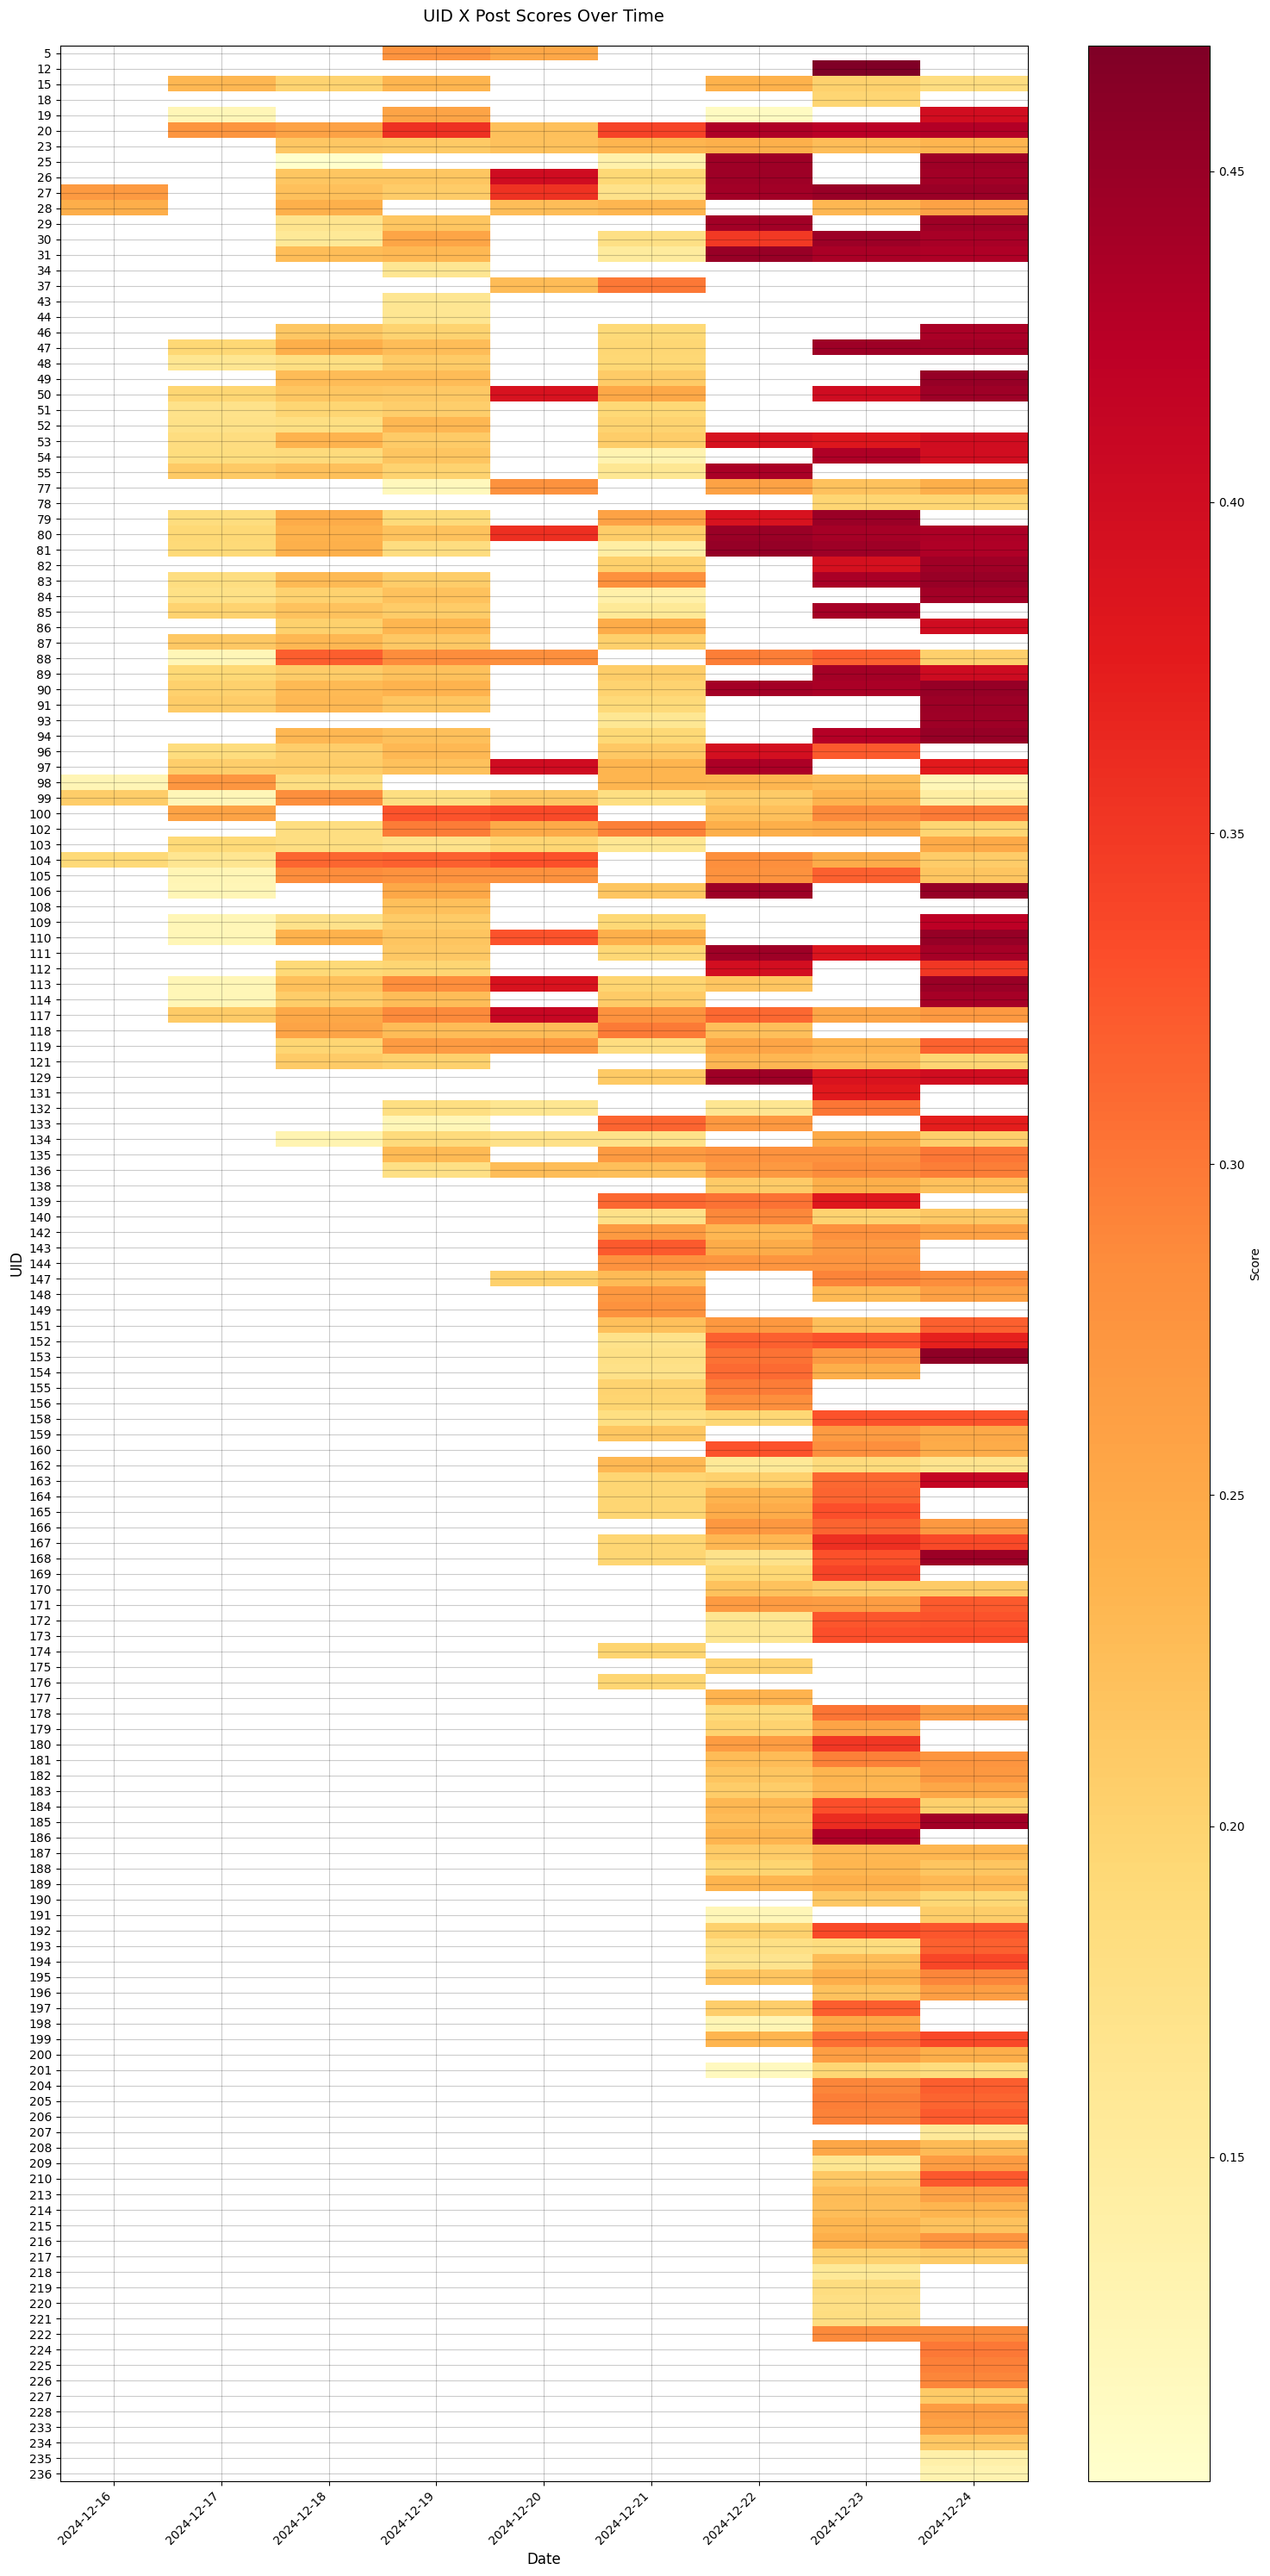

In [96]:
# Create pivot table and sort by UID numerically
df_pivot = pd.pivot_table(
    df_scores,
    values='score',
    index='uid',
    columns=pd.Grouper(key='created_at', freq='D'),
    aggfunc='mean'
).round(3)

# Convert index to numeric and sort
df_pivot.index = pd.to_numeric(df_pivot.index)
df_pivot = df_pivot.sort_index()

# Print summary statistics
print("\nScoring Summary:")
print(f"Total unique UIDs: {len(uid_user_scores)}")
print(f"Total X posts scored: {len(scoring_records)}")
print(f"Date range: {df_scores['created_at'].min().date()} to {df_scores['created_at'].max().date()}")

# Display pivot table
print("\nUID Daily Average Scores:")
display(df_pivot)

# Create an even larger figure with emphasis on height
plt.figure(figsize=(15, 30))

# Create heatmap
plt.imshow(df_pivot, aspect='auto', cmap='YlOrRd')
plt.colorbar(label='Score')

# Improve title and labels
plt.title('UID X Post Scores Over Time', pad=20, fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('UID', fontsize=12)

# Format x-axis (dates)
plt.xticks(range(len(df_pivot.columns)), 
           df_pivot.columns.date, 
           rotation=45, 
           ha='right',
           fontsize=10)

# Format y-axis (UIDs) with more space
y_ticks = range(len(df_pivot.index))
plt.yticks(y_ticks, 
           df_pivot.index, 
           fontsize=10)

# Add gridlines
plt.grid(True, which='major', color='black', alpha=0.2)

# Add spacing between subplots to prevent label overlap
plt.subplots_adjust(left=0.15)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()